# Test reservoir network ability to selectively accumulate temporal patterns

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string, mv_avg
from disp import set_plot, plot_b, colors
from record_3_rsvr import smlt_rsvr
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

(0.0, 20.0)

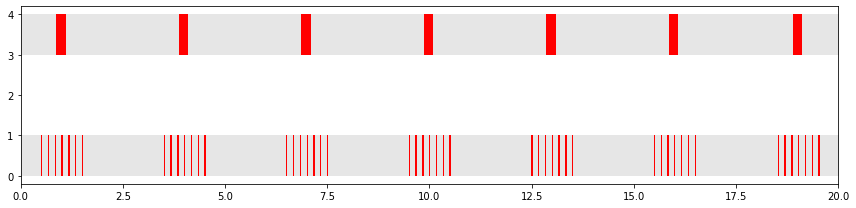

In [2]:
# get snippets
T_SNP = 300  # min snippet length to fetch
NT_SNP = int(round(T_SNP*FPS))
t_snp = np.arange(NT_SNP)*DT

# make two example trials

# short pulses
i_s_0 = np.zeros(NT_SNP)
i_p_0 = np.zeros(NT_SNP)

# long pulses
i_s_1 = np.zeros(NT_SNP)
i_p_1 = np.zeros(NT_SNP)

t_start = 1

while t_start < (T_SNP-10):
    it_start = int(round(t_start*FPS))
    
    # short pulses
    i_p_0[it_start-15] = 1
    i_p_0[it_start-10] = 1
    i_p_0[it_start-5] = 1
    i_p_0[it_start] = 1
    i_p_0[it_start+5] = 1
    i_p_0[it_start+10] = 1
    i_p_0[it_start+15] = 1
    
    # long pulse
    i_p_1[it_start-4:it_start+3] = 1
    
    t_start += 3
    
snp_0 = np.zeros(NT_SNP)
snp_0[i_s_0 == 1] = 1
snp_0[i_p_0 == 1] = 2

snp_1 = np.zeros(NT_SNP)
snp_1[i_s_1 == 1] = 1
snp_1[i_p_1 == 1] = 2

snps = [snp_0, snp_1]
    
fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)
plot_b(ax, t_snp, snps[0], extent=[0, t_snp.max(), 0, 1], c=[(.9, .9, .9), 'b', 'r'])
plot_b(ax, t_snp, snps[1], extent=[0, t_snp.max(), 3, 4], c=[(.9, .9, .9), 'b', 'r'])
ax.set_xlim(0, 20)

In [3]:
y_0 = t_snp.copy()/t_snp.max()
y_1 = np.zeros(len(y_0))

In [4]:
N = 20
ALPHA = 1e-7

In [5]:
taus = np.array([.05, 1, 5, 10])
rads = np.array([.1, .5, .8, .9, .99, 1, 1.01, 1.05, 1.1, 1.5, 2, 10])

y_hats_all = np.nan*np.zeros((len(taus), len(rads), len(y_0), 2))
rms_errs_all = np.nan*np.zeros((len(taus), len(rads)))

for ctau, tau in enumerate(taus):
    sys.stdout.write('>')
    for crad, rad in enumerate(rads):
        sys.stdout.write('.')
        
        w_rec = np.random.randn(N, N)/np.sqrt(N)
        evs = np.linalg.eig(w_rec)[0]
        w_rec *= (rad/np.max(np.abs(evs)))

        w_in = np.random.randn(N, 2)/np.sqrt(2)

        params_rsvr = {'w_rec': w_rec, 'w_in': w_in, 'tau': tau}

        rs_full_rsvr = []

        for snp in snps:

            i_s = (snp == 1).astype(float)
            i_p = (snp == 2).astype(float)

            t_snp = np.arange(len(snp))*DT

            rs_rsvr = smlt_rsvr(i_s, i_p, params_rsvr, DT)
            rs_full_rsvr.append(rs_rsvr)
            
        xs = cc(rs_full_rsvr, axis=0)
        y = cc([y_0, y_1])

        rgr = linear_model.Ridge(alpha=ALPHA)
        rgr.fit(xs, y)

        y_hat_0 = rgr.predict(rs_full_rsvr[0])
        y_hat_1 = rgr.predict(rs_full_rsvr[1])
        
        y_hats_all[ctau, crad, :, 0] = y_hat_0.copy()
        y_hats_all[ctau, crad, :, 1] = y_hat_1.copy()
        
        rms_err = np.sqrt(np.mean(np.array([(y_hat_0 - y_0)**2, (y_hat_1 - y_1)**2])))
        rms_errs_all[ctau, crad] = rms_err

>............>............>............>............

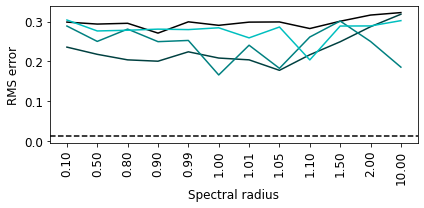

In [18]:
# plot error
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
for ctau, tau in enumerate(taus):
    ax.plot(np.arange(len(rads)), rms_errs_all[ctau, :], c=ctau/4*np.array([0, 1, 1]))
    
ax.axhline(0.011041028741915697, color='k', ls='--')  # MA error

ax.set_xticks(np.arange(len(rads)))
ax.set_xticklabels([f'{rad:.2f}' for rad in rads], rotation=90)
set_plot(ax, x_label='Spectral radius', y_label='RMS error')

fig.savefig('supp/5_temporal_pattern_accum_rsvr_rms_err.svg')

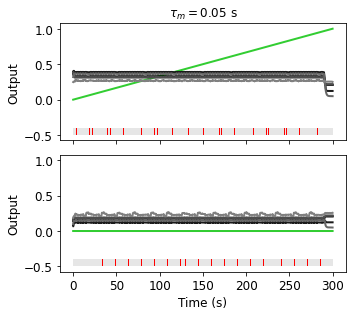

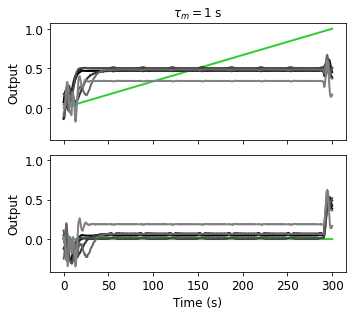

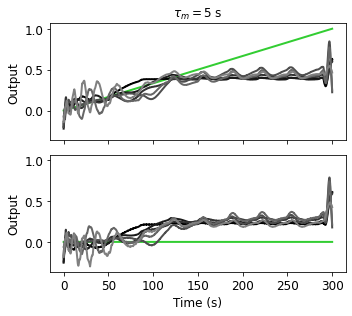

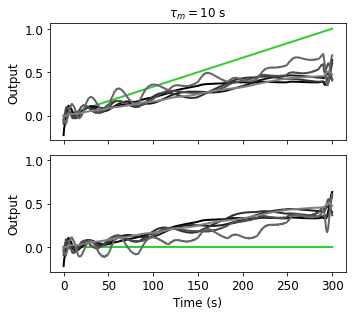

In [7]:
taus_plot = [.05, 1, 5, 10]
rads_plot = [.5, .9, .99, 1.01, 1.1, 2]

for tau in taus_plot:
    itau = np.argmin(np.abs(taus-tau))
    
    fig, axs = plt.subplots(2, 1, figsize=(5, 4.5), tight_layout=True, sharex=True, sharey=True)
    axs[0].plot(t_snp, y_0, c='limegreen', lw=2)
    axs[1].plot(t_snp, y_1, c='limegreen', lw=2)
    
    for crad_plot, rad in enumerate(rads_plot):
        irad = np.argmin(np.abs(rads-rad))
        
        y_hat_0 = y_hats_all[itau, irad, :, 0]
        y_hat_1 = y_hats_all[itau, irad, :, 1]
        axs[0].plot(t_snp, mv_avg(t_snp, y_hat_0, 3), c=np.ones(3)*(crad_plot)/10, lw=2)
        axs[1].plot(t_snp, mv_avg(t_snp, y_hat_1, 3), c=np.ones(3)*(crad_plot)/10, lw=2)
        
    if itau == 0:
        plot_b(axs[0], t_snp, snp_0, [0, 300, -.5, -.4], c=((.9, .9, .9), 'b', 'r'))
        plot_b(axs[1], t_snp, snp_1, [0, 300, -.5, -.4], c=((.9, .9, .9), 'b', 'r'))

    set_plot(axs[0], y_label='Output', title=r'$\tau_m=$' + f'{tau} s')
    set_plot(axs[1], x_label='Time (s)', y_label='Output')

    fig.savefig(f'supp/5_temporal_pattern_accum_rsvr_tau_{tau}.svg')